In [57]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image

In [58]:
DATASET_PATH = "dataset_32/"

LABEL_NORMAL = 0
LABEL_ABNORMAL = 1

AUGMENT_THRESHOLD=6000
AUGMENT_MULTIPLIER=0

BATCH_COUNT=16
EPOCH_COUNT=5
LEARNING_RATE=0.001

MODEL_FILE_NAME="pneumonia_binary_model.pth"

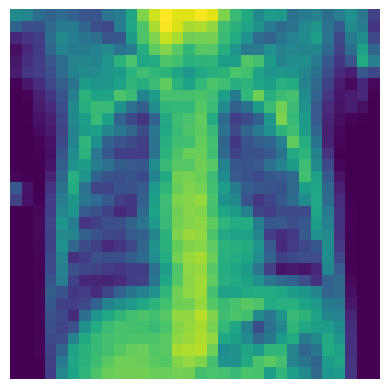

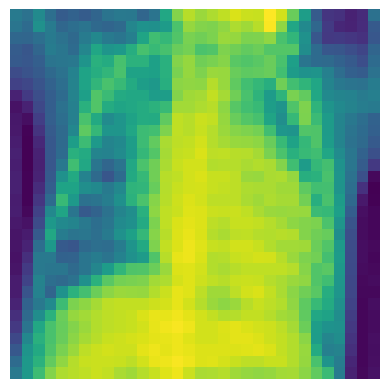

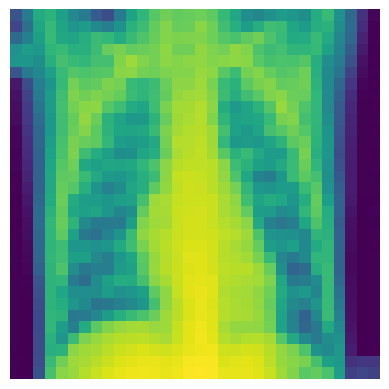

In [59]:
# demo images

normal_train_image = Image.open(DATASET_PATH + "normal_train_0.png")
bacteria_train_image = Image.open(DATASET_PATH + "bacteria_train_0.png")
virus_train_image = Image.open(DATASET_PATH + "virus_train_0.png")

plt.axis("off")
plt.imshow(normal_train_image)
plt.show()

plt.axis("off")
plt.imshow(bacteria_train_image)
plt.show()

plt.axis("off")
plt.imshow(virus_train_image)
plt.show()

In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torchvision.models as models

In [61]:
def AugmentImagesByCategory(category, multiplier, threshold, transformBuffer):
    imageList = []
    imageCount = 0
    
    for subdir, dirs, files in os.walk(DATASET_PATH):
        for file in files:
            if file.find(category) != -1:
                imageCount += 1
                imageList.append(DATASET_PATH + file)
                
    if imageCount < threshold:
        for i in range(multiplier):
            for image in imageList:
                image_buffer = Image.open(image)
                new_image = transformBuffer(image_buffer)
                x = image.split("_")
                new_image.save("{}_{}_{}_{}.png".format(x[0], x[1], x[2], imageCount))
                imageCount += 1
                    
    print("After augmentation we have {} images for category {}".format(imageCount, category))

In [62]:
transformBuffer = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1),
    transforms.RandomAffine(degrees=0, scale=(0.8, 1.2), shear=10)
])

AugmentImagesByCategory("normal_train", AUGMENT_MULTIPLIER, AUGMENT_THRESHOLD, transformBuffer)
AugmentImagesByCategory("bacteria_train", AUGMENT_MULTIPLIER, AUGMENT_THRESHOLD, transformBuffer)
AugmentImagesByCategory("virus_train", AUGMENT_MULTIPLIER, AUGMENT_THRESHOLD, transformBuffer)

After augmentation we have 5364 images for category normal_train
After augmentation we have 10120 images for category bacteria_train
After augmentation we have 5380 images for category virus_train


In [63]:
class PneumoniaDataset(Dataset):
    def __init__(self, category, multiplier=1, transformBuffer=None):
        self.category = category
        self.transformBuffer = transformBuffer
        
        self.count = 0
        self.buffer = []
        
        for subdir, dirs, files in os.walk(DATASET_PATH):
            for file in files:
                if file.find(category) != -1:
                    self.buffer.append(DATASET_PATH + file)
                    self.count += 1
                    
        print("[DEBUG] Found {} examples to {}".format(self.count, self.category))

    def __len__(self):
        return self.count

    def __getitem__(self, index):
        image_path = self.buffer[index]
        label = None
        
        if image_path.find("normal") != -1:
            label = LABEL_NORMAL
        elif image_path.find("bacteria") != -1 or image_path.find("virus") != -1:
            label = LABEL_ABNORMAL
 
        image = Image.open(image_path)

        if self.transformBuffer is not None:
            image = self.transformBuffer(image)

        return image, label

In [64]:
training_dataset = PneumoniaDataset("train", 1, transforms.Compose([ transforms.ToTensor() ]))
test_dataset = PneumoniaDataset("test", 1, transforms.Compose([ transforms.ToTensor() ]))

[DEBUG] Found 20864 examples to train
[DEBUG] Found 624 examples to test


In [65]:
class XRayClassifier(nn.Module):
    def __init__(self):
        super(XRayClassifier, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(1024, 32)
        self.relu5 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(32, 2)


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.pool4(x)
        
        x = x.view(x.size(0), -1)  # Flatten the tensor
        
        x = self.fc1(x)
        x = self.relu5(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        return x

In [66]:
def trainModel(training_dataset, batchSize, epochCount, learningRate, loadFromDisk=False):
    model = XRayClassifier()
    model.train()
    
    if loadFromDisk:
        model.load_state_dict(torch.load(MODEL_FILE_NAME))
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learningRate)

    dataset = training_dataset
    dataloader = DataLoader(dataset, batch_size=batchSize, shuffle=True)

    loss_buffer = []
    
    for epoch in range(epochCount):
        running_loss = 0.0
        for i, data in enumerate(dataloader):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        average_loss = running_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{epochCount}], Loss: {average_loss:.4f}")
        loss_buffer.append(average_loss)
        torch.save(model.state_dict(), MODEL_FILE_NAME)
    return loss_buffer

In [67]:
def testModel(batchSize, testing_dataset):
    model = XRayClassifier()
    model.load_state_dict(torch.load(MODEL_FILE_NAME))
    model.eval()

    dataset = testing_dataset
    dataloader = DataLoader(dataset, batch_size=batchSize, shuffle=False)
    
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

Epoch [1/5], Loss: 0.3170
Epoch [2/5], Loss: 0.1570
Epoch [3/5], Loss: 0.1292
Epoch [4/5], Loss: 0.1099
Epoch [5/5], Loss: 0.0943
Training took 168 seconds, or 3 minutes
Model accuracy is 82.05%


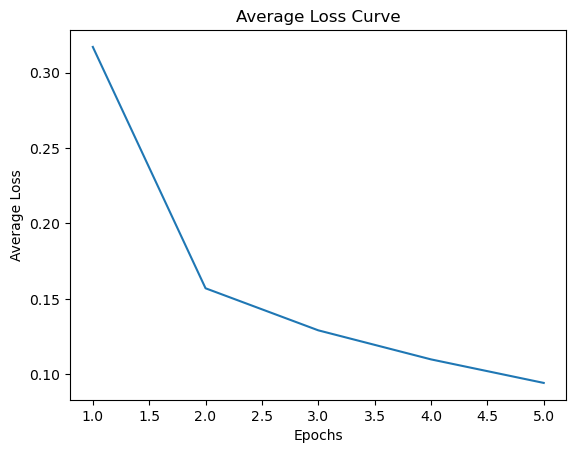

In [68]:
import time


t0 = time.time()
loss_buffer = trainModel(training_dataset, 
                         batchSize=BATCH_COUNT,
                         epochCount=EPOCH_COUNT,
                         learningRate=LEARNING_RATE,
                         loadFromDisk=False)
t1 = time.time()

print(f"Training took {(t1 - t0):.0f} seconds, or {((t1 - t0) / 60):.0f} minutes")
    
accuracy = testModel(BATCH_COUNT, test_dataset)
print(f"Model accuracy is {accuracy:.2f}%")
    
epochs = range(1, len(loss_buffer) + 1)
plt.plot(epochs, loss_buffer)
plt.title('Average Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.show()

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [70]:
def testAndBuildConfusionMatrixForModel(batchSize, testing_dataset):
    model = XRayClassifier()
    model.load_state_dict(torch.load(MODEL_FILE_NAME))
    model.eval()

    dataset = testing_dataset
    dataloader = DataLoader(dataset, batch_size=batchSize, shuffle=False)

    correct = 0
    total = 0
    predicted_labels = []
    true_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            predicted_labels.extend(predicted.tolist())
            true_labels.extend(labels.tolist())

    accuracy = 100 * correct / total
    
    cm = confusion_matrix(true_labels, predicted_labels)
    
    classes = [ "Healthy", "Diseased" ]
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

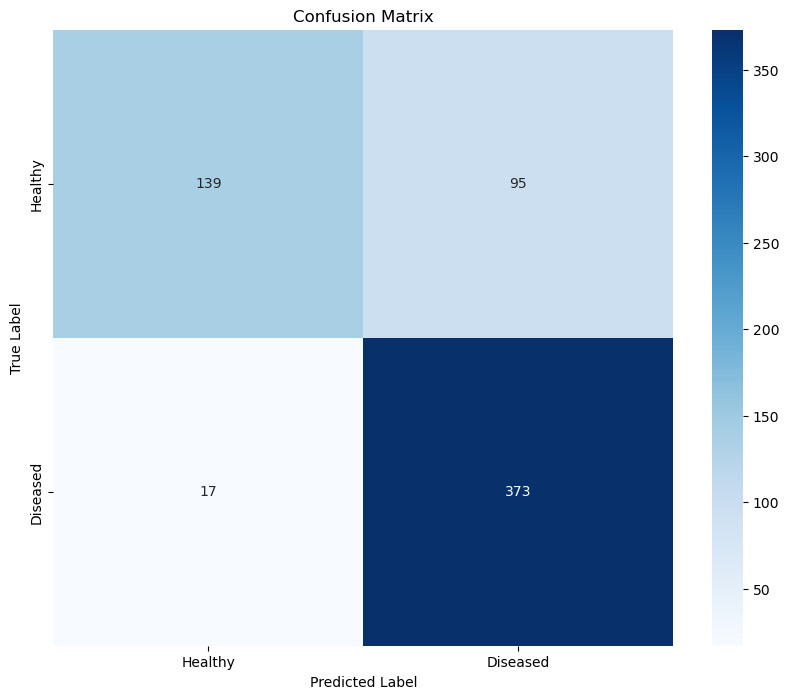

In [71]:
testAndBuildConfusionMatrixForModel(BATCH_COUNT, test_dataset)